In [1]:
import numpy as np
import time
from dataset import ptb
import matplotlib.pyplot as plt

In [2]:
class Rnnlm:
    
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed = (rn(V, D) / 100).astype('f')
        rnnWx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnnWh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnnb = np.zeros(H).astype('f')
        affineW = (rn(H, V) / np.sqrt(H)).astype('f')
        affineb = np.zeros(V).astype('f')
        
        self.params = [embed, rnnWx, rnnWh, rnnb, affineW, affineb]
        self.grads = []
        self.rnn = []
        
        self.wordvec_size = wordvec_size
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.time_idx = 0
    
    def forward(self, x, t):
        embed, rnnWx, rnnWh, rnnb, affineW, affineb = self.params
                
        batch_size, time_size = x.shape
        wordvec_size = self.wordvec_size
        hidden_size = self.hidden_size
        
        self.rnn = []
        
        h_prev = np.zeros((batch_size, hidden_size), dtype='f')
        hs = np.empty((batch_size, time_size, hidden_size), dtype='f')
        for t in range(time_size):
            # embed
            emb_out = embed[x[:, t]]
            
            #rnn
            h_next = np.matmul(h_prev, rnnWh) + np.matmul(emb_out, rnnWx) + rnnb
            h_next = np.tanh(h_next)
            
            self.rnn.append([emb_out, h_prev, h_next])
            h_prev = h_next
            hs[:, t, :] = h_prev
        
        # affine
        affine_out = np.matmul(hs, affineW) + affineb
        
        # softmax
        y = self.softmax(affine_out)
        
        loss = self.getLoss(y, batch_t)
        self.xs = x, hs, affine_out, y

        return y, loss
    
    def backward(self, t):
        embed, rnnWx, rnnWh, rnnb, affineW, affineb = self.params
        x, hs, affine_out, y = self.xs
        
        wordvec_size = self.wordvec_size
        vocab_size = self.vocab_size
        batch_size, time_size = x.shape
        
        # softmax
        y = y.reshape(batch_size * time_size, -1)
        t = t.reshape(batch_size * time_size)
        y[np.arange(batch_size * time_size), t] -= 1
        soft_dout = y
        
        # affine
        affine_dout = np.matmul(soft_dout, affineW.T).reshape(batch_size, time_size, -1) 
        affinedW = np.matmul(hs.reshape(batch_size * time_size, -1).T, soft_dout) 
        affinedb = np.sum(soft_dout, axis=0)
        
        # rnn
        rnndWx = np.zeros_like(rnnWx)
        rnndWh = np.zeros_like(rnnWh)
        rnndb = np.zeros_like(rnnb)
        
        rnn_douts = np.empty((batch_size, time_size, wordvec_size), dtype='f')
        dh = 0
        for t in reversed(range(time_size)):
            emb_out, h_prev, h_next = self.rnn[t]
            
            dh_next = affine_dout[:, t, :] + dh
            tanh_dout = dh_next * (1 - h_next ** 2)
            
            dWx = np.matmul(emb_out.T, tanh_dout)
            rnn_dout = np.matmul(tanh_dout, rnnWx.T)
            rnn_douts[:, t, :] = rnn_dout
            
            dWh = np.matmul(h_prev.T, tanh_dout)
            dh_prev = np.matmul(tanh_dout, rnnWh.T)
            
            db = np.sum(tanh_dout, axis=0)
            
            rnndWx += dWx
            rnndWh += dWh
            rnndb += db
            
            dh = dh_prev
        
        # embed
        embed_dout = np.zeros_like(embed)
        for t in range(time_size):
            np.add.at(embed_dout, x[:, t], rnn_douts[:, t, :])
        
        self.grads = embed_dout, rnndWx, rnndWh, rnndb, affinedW, affinedb
        
        
    def softmax(self, y):
        y = y - np.max(y)
        y = np.exp(y)
        y = y / y.sum(axis=2, keepdims=True)
        return y
    
    def update(self, lr):
        for i in range(len(self.params)):
            self.params[i] -= self.grads[i] * lr      
            
    def getLoss(self, y, t):
        N, T, V = y.shape

        y = y.reshape(N * T, V)
        t = t.reshape(N * T)

        ls = np.log(y[np.arange(N * T), t])
        return -np.sum(ls) / (N * T)
    
    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

In [3]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1] 
ts = corpus[1:]  

batch_size = 10
wordvec_size = 100
hidden_size = 100  
time_size = 5  
lr = 0.01
max_epoch = 100
max_iters = len(xs) // (batch_size * time_size)
eval_interval = 20

In [4]:
model = Rnnlm(vocab_size, wordvec_size, hidden_size)

In [5]:
ppl_list = []
total_loss = 0
loss_count = 0
start_time = time.time()
model.time_idx = 0
for epoch in range(max_epoch):
    for iters in range(max_iters):
        batch_x, batch_t = model.get_batch(xs, ts, batch_size, time_size)

        y, loss = model.forward(batch_x, batch_t)
        model.backward(batch_t)
        model.update(lr)
        
        total_loss += loss
        loss_count += 1

        if ((iters % eval_interval) == 0):
            ppl = np.exp(total_loss / loss_count)
            elapsed_time = time.time() - start_time
            print('| epoch %d | time %d[s] | loss %.2f | ppl %.2f'
                % (epoch + 1, elapsed_time, loss, ppl))
            ppl_list.append(float(ppl))
            total_loss, loss_count = 0, 0

| epoch 1 | time 0[s] | loss 6.03 | ppl 417.69
| epoch 2 | time 0[s] | loss 5.25 | ppl 307.44
| epoch 3 | time 0[s] | loss 5.61 | ppl 236.34
| epoch 4 | time 0[s] | loss 5.53 | ppl 214.06
| epoch 5 | time 0[s] | loss 5.07 | ppl 203.11
| epoch 6 | time 0[s] | loss 5.26 | ppl 192.38
| epoch 7 | time 1[s] | loss 5.16 | ppl 176.55
| epoch 8 | time 1[s] | loss 5.29 | ppl 167.06
| epoch 9 | time 1[s] | loss 5.07 | ppl 152.21
| epoch 10 | time 1[s] | loss 5.04 | ppl 138.19
| epoch 11 | time 1[s] | loss 4.89 | ppl 124.06
| epoch 12 | time 1[s] | loss 4.86 | ppl 114.28
| epoch 13 | time 1[s] | loss 4.72 | ppl 104.96
| epoch 14 | time 2[s] | loss 4.51 | ppl 89.09
| epoch 15 | time 2[s] | loss 4.11 | ppl 76.86
| epoch 16 | time 2[s] | loss 4.13 | ppl 69.69
| epoch 17 | time 2[s] | loss 4.11 | ppl 60.19
| epoch 18 | time 2[s] | loss 4.24 | ppl 52.98
| epoch 19 | time 2[s] | loss 4.00 | ppl 42.30
| epoch 20 | time 3[s] | loss 3.78 | ppl 37.76
| epoch 21 | time 3[s] | loss 3.41 | ppl 33.22
| epoch 2

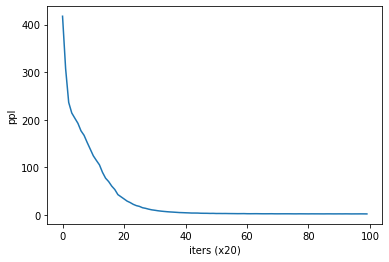

In [6]:
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('iters (x' + str(eval_interval) + ')')
plt.ylabel('ppl')
plt.show()